In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import os


#Storing the frames in list
def preprocess_video(video_path, target_size=(64, 64), max_frames=16):
    """
    Extract, resize, and normalize frames from a video file.
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // max_frames)
    
    for i in range(0, frame_count, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resizing the frame to the target size
        frame_resized = cv2.resize(frame, target_size)
        
        # Normalizing the frame by scaling pixel values to [0, 1]
        frame_normalized = frame_resized / 255.0
        
        frames.append(frame_normalized)
        
        if len(frames) >= max_frames:
            break
    
    cap.release()
    return np.array(frames)

def load_and_preprocess_dataset(data_path, target_size=(64, 64), max_frames=16):
    """
    Load and preprocess the entire dataset.
    """
    videos = []
    labels = []
    class_names = sorted(os.listdir(data_path))  # Sort class names for consistency

    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):  # Ensure the path is a directory
            video_files = os.listdir(class_path)
            for video_file in tqdm(video_files, desc=f"Processing {class_name}"):
                video_path = os.path.join(class_path, video_file)
                if video_path.endswith(('.mp4', '.avi', '.mov')):  # Filter for video files
                    frames = preprocess_video(video_path, target_size, max_frames)
                    videos.append(frames)
                    labels.append(class_name)  # Label each video with the class name
    
    return np.array(videos), np.array(labels)

# Define the path to the dataset
data_path = '/kaggle/input/ucf-12/UCF'  # Update this to your dataset path

# Load and preprocess the dataset
videos, labels = load_and_preprocess_dataset(data_path)

print(f"Processed videos shape: {videos.shape}")
print(f"Labels shape: {labels.shape}")


Processing CuttingInKitchen: 100%|██████████| 110/110 [00:18<00:00,  5.89it/s]


Processed videos shape: (1694, 16, 64, 64, 3)
Labels shape: (1694,)


In [2]:
import numpy as np

# Get unique labels and their indices
unique_labels, indices = np.unique(labels, return_index=True)

# Sort indices 
sorted_indices = np.argsort(indices)
unique_labels = unique_labels[sorted_indices]

# Count occurrences of each unique label
counts = [np.sum(labels == label) for label in unique_labels]

print("Unique labels:", unique_labels)
print("Counts:", counts)
print("Number of unique labels:", len(unique_labels))


Unique labels: ['BaseballPitch' 'Basketball' 'BenchPress' 'Biking' 'Billiards' 'Bowling'
 'BoxingPunchingBag' 'BreastStroke' 'BrushingTeeth' 'CricketBowling'
 'CricketShot' 'CuttingInKitchen']
Counts: [150, 134, 160, 134, 150, 155, 163, 101, 131, 139, 167, 110]
Number of unique labels: 12


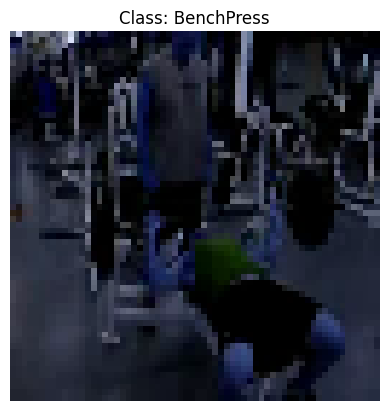

In [3]:
import matplotlib.pyplot as plt


video_index = 284

frame = videos[video_index][13]

if frame.max() <= 1.0:
    frame = (frame * 255).astype(np.uint8)

# Plot the frame
plt.imshow(frame)
plt.title(f"Class: {labels[video_index]}")
plt.axis('off') 
plt.show()


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout



def create_3d_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    return model

# Define input shape and number of classes
input_shape = (16, 64, 64, 3)
num_classes = len(np.unique(labels))

# Create the model
model = create_3d_cnn(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


2024-06-16 21:32:39.648256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 21:32:39.648349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 21:32:39.776918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 64, 64, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 32, 32, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 32, 32, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 16, 16, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,674,572 (33.09 MB)

 Trainable params: 8,674,572 (33.09 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(videos, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [6]:
unique_labels_one_hot, counts = np.unique(labels_one_hot, axis=0, return_counts=True)

# Print the unique one-hot encoded labels and their counts
print("Unique one-hot encoded labels and their counts:")
for label, count in zip(unique_labels_one_hot, counts):
    print(f"Label: {label}, Count: {count}")

# Print counts in order
print("Counts in order:")
print(counts)

Unique one-hot encoded labels and their counts:
Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], Count: 110
Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], Count: 167
Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], Count: 139
Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], Count: 131
Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], Count: 101
Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], Count: 163
Label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], Count: 155
Label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], Count: 150
Label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], Count: 134
Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Count: 160
Label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Count: 134
Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Count: 150
Counts in order:
[110 167 139 131 101 163 155 150 134 160 134 150]


In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)




lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)


In [8]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Epoch 1/50
 2/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1250 - loss: 3.0097  

I0000 00:00:1718573585.929576    6885 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718573585.946949    6885 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.1868 - loss: 2.4098

W0000 00:00:1718573593.345774    6884 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.1881 - loss: 2.4055 - val_accuracy: 0.5906 - val_loss: 1.4148 - learning_rate: 0.0010
Epoch 2/50
 1/75 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5000 - loss: 1.7265

W0000 00:00:1718573595.010639    6887 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5295 - loss: 1.4347 - val_accuracy: 0.6299 - val_loss: 1.1095 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6782 - loss: 0.9303 - val_accuracy: 0.7205 - val_loss: 0.8140 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7703 - loss: 0.6813 - val_accuracy: 0.8189 - val_loss: 0.5262 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8732 - loss: 0.4038 - val_accuracy: 0.8937 - val_loss: 0.3663 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9182 - loss: 0.2412 - val_accuracy: 0.9016 - val_loss: 0.2356 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9416 - loss: 0.1742 - val_accuracy: 0.9094 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9411 - loss: 0.1917 - val_accuracy: 0.92

W0000 00:00:1718573669.900303    6886 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.9237 - loss: 0.2064
Test accuracy: 0.9216


W0000 00:00:1718573672.503305    6884 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


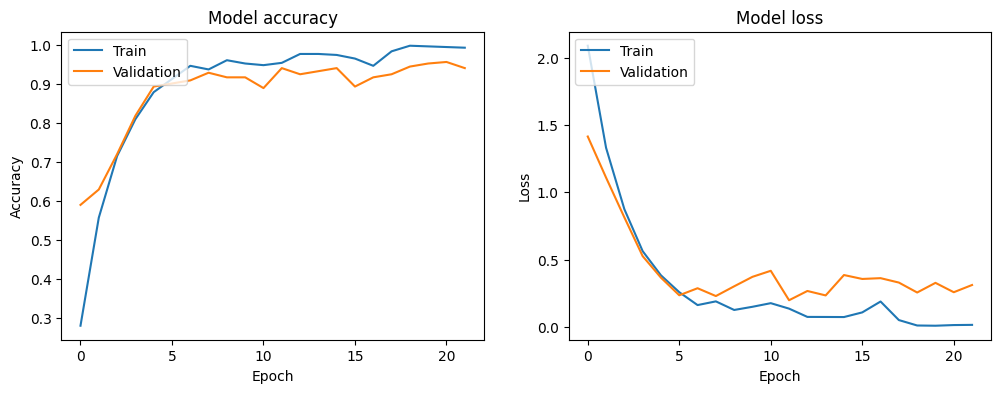

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

W0000 00:00:1718573674.189072    6886 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


W0000 00:00:1718573674.826804    6887 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


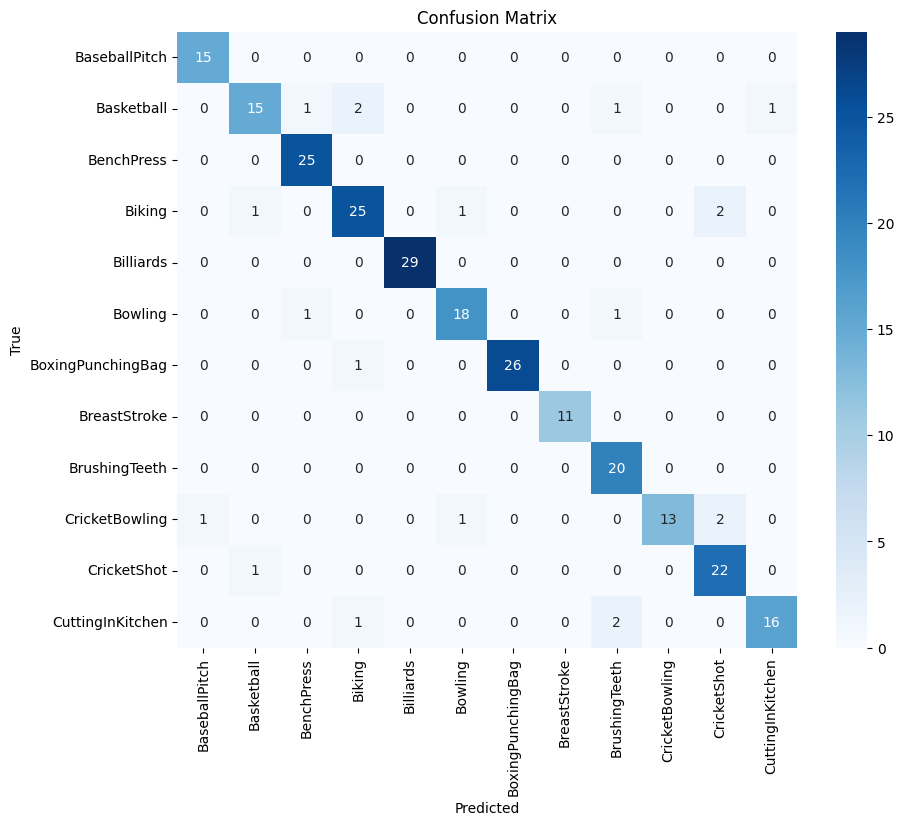

                   precision    recall  f1-score   support

    BaseballPitch       0.94      1.00      0.97        15
       Basketball       0.88      0.75      0.81        20
       BenchPress       0.93      1.00      0.96        25
           Biking       0.86      0.86      0.86        29
        Billiards       1.00      1.00      1.00        29
          Bowling       0.90      0.90      0.90        20
BoxingPunchingBag       1.00      0.96      0.98        27
     BreastStroke       1.00      1.00      1.00        11
    BrushingTeeth       0.83      1.00      0.91        20
   CricketBowling       1.00      0.76      0.87        17
      CricketShot       0.85      0.96      0.90        23
 CuttingInKitchen       0.94      0.84      0.89        19

         accuracy                           0.92       255
        macro avg       0.93      0.92      0.92       255
     weighted avg       0.92      0.92      0.92       255



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


In [11]:
import pickle

# Save the model
model.save('3d_cnn_model_final.h5')

# Save the training history
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

print("Model, training history, and label encoder saved successfully.")


Model, training history, and label encoder saved successfully.


In [15]:
import tensorflow as tf
import pickle

# Load the model
model = tf.keras.models.load_model('3d_cnn_model_final.h5')

# Load the label encoder
with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

print("Model and label encoder loaded successfully.")


Model and label encoder loaded successfully.


In [16]:
import cv2
import numpy as np

def preprocess_video(video_path, target_size=(64, 64), max_frames=16):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // max_frames)
    
    for i in range(0, frame_count, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, target_size)
        frame_normalized = frame_resized / 255.0
        frames.append(frame_normalized)
        
        if len(frames) >= max_frames:
            break
    
    cap.release()
    return np.array(frames)


In [20]:
def predict_video_class(video_path):
    # Preprocess the video
    preprocessed_video = preprocess_video(video_path)
    if preprocessed_video.shape != (16, 64, 64, 3):
        raise ValueError(f"Expected video shape (16, 64, 64, 3), but got {preprocessed_video.shape}")
    
    # Display the first frame of the video
    first_frame = preprocessed_video[0]
    plt.imshow(first_frame)
    plt.title("First Frame of the Video")
    plt.axis('off')
    plt.show()
    
    # Add a batch dimension
    preprocessed_video = np.expand_dims(preprocessed_video, axis=0)
    
    # Make predictions
    predictions = model.predict(preprocessed_video)
    
    # Print prediction probabilities
    for idx, prob in enumerate(predictions[0]):
        class_label = label_encoder.inverse_transform([idx])[0]
        print(f"Class: {class_label}, Probability: {prob:.4f}")
    
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    
    # Decode the predicted class index to get the class label
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
    
    return predicted_class_label


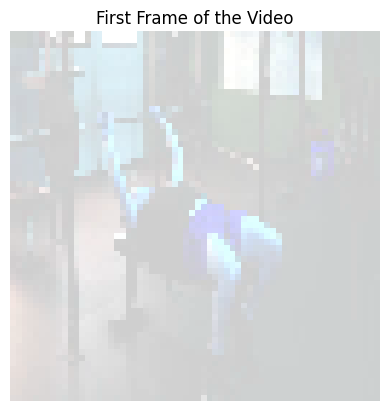

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class: BaseballPitch, Probability: 0.0000
Class: Basketball, Probability: 0.0000
Class: BenchPress, Probability: 0.0956
Class: Biking, Probability: 0.0000
Class: Billiards, Probability: 0.0000
Class: Bowling, Probability: 0.0000
Class: BoxingPunchingBag, Probability: 0.9037
Class: BreastStroke, Probability: 0.0000
Class: BrushingTeeth, Probability: 0.0000
Class: CricketBowling, Probability: 0.0000
Class: CricketShot, Probability: 0.0006
Class: CuttingInKitchen, Probability: 0.0000
The predicted class for the video is: BoxingPunchingBag


In [21]:
# Path to the new video file
new_video_path = '/kaggle/input/bench-press/bench press.mp4'

# Predict the class of the new video
predicted_class = predict_video_class(new_video_path)
print(f"The predicted class for the video is: {predicted_class}")
